<a href="https://colab.research.google.com/github/delpretemarcus/156StockClosingPricePrediction/blob/main/DataCleaningAndExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Genuinely not sure which of these I use... Will trim as necessary
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [4]:

aplurl = 'https://raw.githubusercontent.com/delpretemarcus/156StockClosingPricePrediction/main/HistoricalQuotes.csv'

df = pd.read_csv(aplurl, index_col='Date')

In [5]:
#Data Cleaning --

df.columns = ['Close', 'Volume', 'Open', 'High', 'Low']
df.index = pd.to_datetime(df.index)
df.sort_index()

df.Close = df.Close.apply(lambda x: x[2:]).astype(np.double)
df.Open = df.Open.apply(lambda x: x[2:]).astype(np.double)
df.High = df.High.apply(lambda x: x[2:]).astype(np.double)
df.Low = df.Low.apply(lambda x: x[2:]).astype(np.double)


df = df.reindex(index=df.index[::-1])


In [ ]:
#Clean the data



In [7]:
#Scaling
features = ['Open', 'High', 'Low', 'Volume']
scaler = MinMaxScaler()
with_transform = scaler.fit_transform(df[features])
with_transform= pd.DataFrame(columns=features, data=with_transform, index=df.index)
with_transform.head()

,Open,High,Low,Volume
Date,,,,
2010-03-01,0.000000,0.000000,0.003004,0.279219
2010-03-02,0.002022,0.000638,0.004113,0.288472
2010-03-03,0.001543,0.000177,0.004210,0.180643
2010-03-04,0.001707,0.000681,0.004544,0.173428
2010-03-05,0.004445,0.004891,0.007451,0.472832


In [8]:
#Splitting to Training set and Test set
output_var = pd.DataFrame(df['Close'])
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(with_transform):
  X_train, X_test = with_transform[:len(train_index)], with_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [ ]:
\

In [9]:
y_train

array([ 29.8557,  29.8357,  29.9043, ..., 191.24  , 194.02  , 195.35  ])

In [10]:
#Process the data for LSTM
trainXnp = np.array(X_train)
testXnp = np.array(X_test)
X_train = trainXnp.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testXnp.reshape(X_test.shape[0], 1, X_test.shape[1])

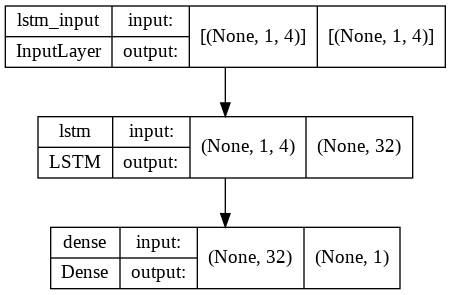

In [11]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainXnp.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [12]:

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [13]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)


Epoch 1/100
287/287 [==============================] - 2s 3ms/step - loss: 12348.9639 - accuracy: 0.0000e+00
Epoch 2/100
287/287 [==============================] - 1s 3ms/step - loss: 10724.3096 - accuracy: 0.0000e+00
Epoch 3/100
287/287 [==============================] - 1s 3ms/step - loss: 7871.3369 - accuracy: 0.0000e+00
Epoch 4/100
287/287 [==============================] - 1s 4ms/step - loss: 4865.1274 - accuracy: 0.0000e+00
Epoch 5/100
287/287 [==============================] - 1s 3ms/step - loss: 2596.2166 - accuracy: 0.0000e+00
Epoch 6/100
287/287 [==============================] - 1s 3ms/step - loss: 1303.5914 - accuracy: 0.0000e+00
Epoch 7/100
287/287 [==============================] - 1s 3ms/step - loss: 739.0327 - accuracy: 0.0000e+00
Epoch 8/100
287/287 [==============================] - 1s 3ms/step - loss: 533.3089 - accuracy: 0.0000e+00
Epoch 9/100
287/287 [==============================] - 1s 3ms/step - loss: 444.5005 - accuracy: 0.0000e+00
Epoch 10/100
287/287 [=======

In [14]:
y_pred = lstm.predict(X_test)
#Might want to inverse our predicted... How?

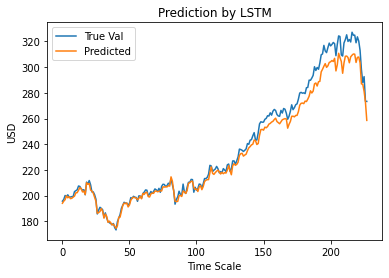

In [15]:
plt.plot(y_test, label='True Val')
plt.plot(y_pred, label='Predicted')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

# New Section
End of Code that works. The rest is just trial stuff.

In [ ]:
#Maybe add Covid cases... / general covid sentiment. Seems to be quite poor indicator as covid begins

In [ ]:
#NVM WAS PRECOVID...



In [54]:
scaler.inverse_transform(lemon)

array([[1.38145166e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.40659752e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.43258808e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.44022575e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.47326034e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.46144645e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.45613020e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.44440196e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.44783981e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.42111088e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.41102773e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.41216777e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.40073193e+04, 2.99286000e+01, 2.84643000e+01, 1.13620500e+07],
       [1.39347525e+04, 2.99286000e+01, 2.84643000e

In [42]:
y_test.reshape(-1,1).shape

(228, 1)

In [44]:
y_test.shape

(228,)

In [45]:
np.zeros(shape = (288,4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [52]:
lemon = np.append(y_test.reshape(-1,1), np.zeros(shape=(228,3)) , axis=1)

In [53]:
lemon

array([[46.6743,  0.    ,  0.    ,  0.    ],
       [47.5257,  0.    ,  0.    ,  0.    ],
       [48.4057,  0.    ,  0.    ,  0.    ],
       [48.6643,  0.    ,  0.    ,  0.    ],
       [49.7828,  0.    ,  0.    ,  0.    ],
       [49.3828,  0.    ,  0.    ,  0.    ],
       [49.2028,  0.    ,  0.    ,  0.    ],
       [48.8057,  0.    ,  0.    ,  0.    ],
       [48.9221,  0.    ,  0.    ,  0.    ],
       [48.0171,  0.    ,  0.    ,  0.    ],
       [47.6757,  0.    ,  0.    ,  0.    ],
       [47.7143,  0.    ,  0.    ,  0.    ],
       [47.3271,  0.    ,  0.    ,  0.    ],
       [47.0814,  0.    ,  0.    ,  0.    ],
       [46.08  ,  0.    ,  0.    ,  0.    ],
       [46.2371,  0.    ,  0.    ,  0.    ],
       [46.47  ,  0.    ,  0.    ,  0.    ],
       [46.4957,  0.    ,  0.    ,  0.    ],
       [46.3828,  0.    ,  0.    ,  0.    ],
       [46.2286,  0.    ,  0.    ,  0.    ],
       [46.4514,  0.    ,  0.    ,  0.    ],
       [46.315 ,  0.    ,  0.    ,  0.    ],
       [46

Type 2: (AutoRegressive)... (With/without Covid Data

In [ ]:
#VAR vs ARIMA?

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2020-02-28,273.3600,106721200,257.2600,278.4100,256.3700
2020-02-27,273.5200,80151380,281.1000,286.0000,272.9600
2020-02-26,292.6500,49678430,286.5300,297.8800,286.5000
2020-02-25,288.0800,57668360,300.9500,302.5300,286.1300
2020-02-24,298.1800,55548830,297.2600,304.1800,289.2300
...,...,...,...,...,...
2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614
2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057


In [ ]:
#Make data stationary...
#Question on regularization
stationary = df.diff().fillna(0)

In [ ]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2020-02-28,273.3600,106721200,257.2600,278.4100,256.3700
2020-02-27,273.5200,80151380,281.1000,286.0000,272.9600
2020-02-26,292.6500,49678430,286.5300,297.8800,286.5000
2020-02-25,288.0800,57668360,300.9500,302.5300,286.1300
2020-02-24,298.1800,55548830,297.2600,304.1800,289.2300
...,...,...,...,...,...
2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614
2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057


In [ ]:
stationary

,Close,Volume,Open,High,Low
Date,,,,,
2020-02-28,0.0000,0.0,0.0000,0.0000,0.0000
2020-02-27,0.1600,-26569820.0,23.8400,7.5900,16.5900
2020-02-26,19.1300,-30472950.0,5.4300,11.8800,13.5400
2020-02-25,-4.5700,7989930.0,14.4200,4.6500,-0.3700
2020-02-24,10.1000,-2119530.0,-3.6900,1.6500,3.1000
...,...,...,...,...,...
2010-03-05,-0.0185,117320595.0,-0.7243,-0.0557,-0.5172
2010-03-04,-1.1772,-135055520.0,-0.8086,-1.2543,-0.8571
2010-03-03,-0.1971,3254581.0,-0.0485,-0.1500,-0.0986


In [ ]:
model = VAR(stationary)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model

In [ ]:
results = model.fit(maxlags=31,ic='aic')

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 29, May, 2022
Time:                     00:51:48
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    35.1282
Nobs:                     2494.00    HQIC:                   34.2288
Log likelihood:          -59133.0    FPE:                4.39377e+14
AIC:                      33.7160    Det(Omega_mle):     3.46706e+14
--------------------------------------------------------------------
Results for equation Close
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.038301         0.026331           -1.455           0.146
L1.Close          -1.164103         0.043105          -27.006           0.000
L1.Volume         -0.000000         0.000000           -0.534           

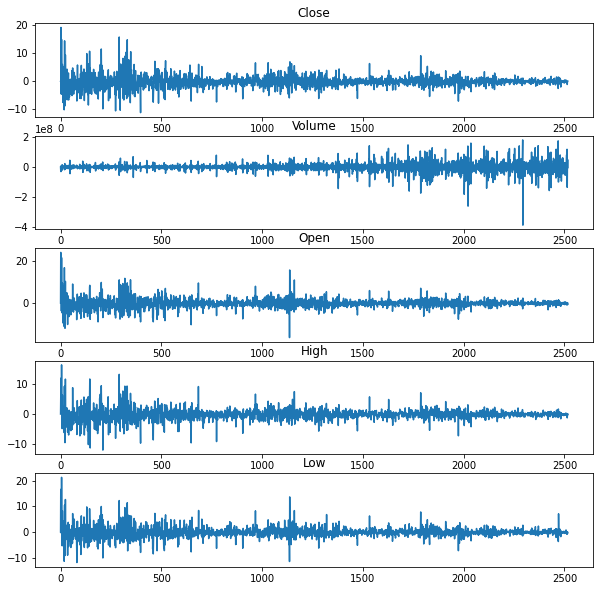

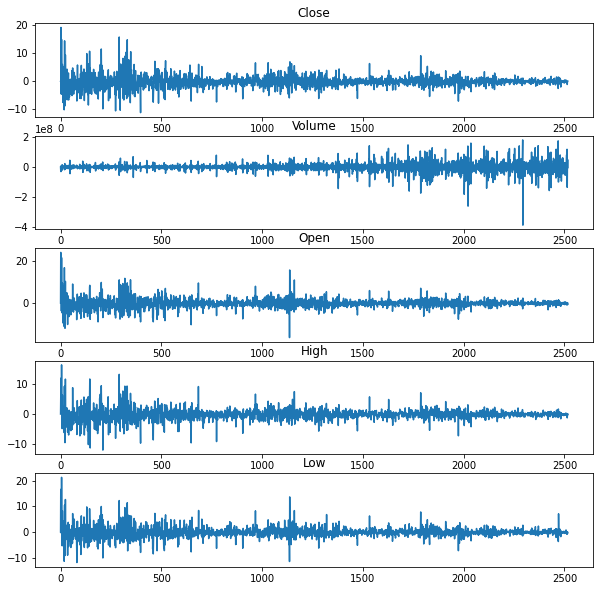

In [ ]:
results.plot()

We Are Beginning Our Arima Test, Just to see what happens...

In [ ]:

# fit an ARIMA model and plot residual errors

from statsmodels.tsa import arima_model

In [ ]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2020-02-28,273.3600,106721200,257.2600,278.4100,256.3700
2020-02-27,273.5200,80151380,281.1000,286.0000,272.9600
2020-02-26,292.6500,49678430,286.5300,297.8800,286.5000
2020-02-25,288.0800,57668360,300.9500,302.5300,286.1300
2020-02-24,298.1800,55548830,297.2600,304.1800,289.2300
...,...,...,...,...,...
2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614
2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057


In [ ]:
lemon = df.Close.diff().fillna(0)

In [ ]:
lemon

Date
2020-02-28     0.0000
2020-02-27     0.1600
2020-02-26    19.1300
2020-02-25    -4.5700
2020-02-24    10.1000
               ...   
2010-03-05    -0.0185
2010-03-04    -1.1772
2010-03-03    -0.1971
2010-03-02    -0.0686
2010-03-01     0.0200
Name: Close, Length: 2518, dtype: float64

In [ ]:
import statsmodels

In [ ]:
what = df.Close.copy(deep=True)

In [ ]:
model = statsmodels.tsa.arima_model.ARIMA(what, order=(5,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model_fit = model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2517
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5422.939
Method:                       css-mle   S.D. of innovations              2.087
Date:                Sun, 29 May 2022   AIC                          10859.877
Time:                        19:03:06   BIC                          10900.693
Sample:                             1   HQIC                         10874.690
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0957      0.045     -2.136      0.033      -0.184      -0.008
ar.L1.D.Close     0.0153      0.020      0.770      0.442      -0.024       0.054
ar.L2.D.Close    -0.0353      0.020     -1.742      0.082      -0.075       0.004
ar.L3.D.Close    -0.0234      0.020     -1.155      0.248      -0.063       0.016
ar.L4.D.Close     0.0749      0.020      3.685      0.000       0.035       0.115
ar.L5.D.Close     0.0404      0.021      1.961      0.050    1.64e-05       0.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6969           -0.0000j            1.6969           -0.0000
AR.2            0.3088           -1.6397j            1.6685           -0.2204
AR.3            0.3088           +1.6397j            1.6685            0.2204
AR.4           -2.0843           -0.9453j            2.2886           -0.4322
AR.5           -2.0843           +0.9453j            2.2886            0.4322
-----------------------------------------------------------------------------
"""

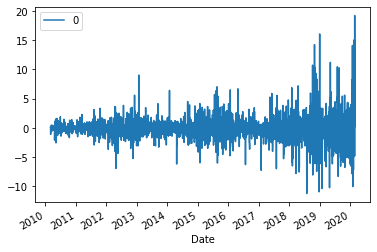

In [ ]:
residuals = DataFrame(model_fit.resid)
residuals.plot()

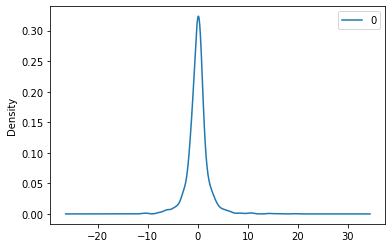

In [ ]:
# density plot of residuals
residuals.plot(kind='kde')